In [38]:
# ---- Setup: Install dependencies ----
!python3 -m pip install -q pandas numpy scikit-learn matplotlib yfinance xgboost torch
!python3 -m pip install -q transformers
import yfinance as yf
import pandas as pd

spy = yf.download("SPY", start="2015-01-01", auto_adjust=True)

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Check the data structure
print(f"Data shape: {spy.shape}")
print(f"Date range: {spy.index[0]} to {spy.index[-1]}")
print(f"Columns: {spy.columns.tolist()}")

# Check for missing values
print(f"Missing values: {spy.isnull().sum().sum()}")

# Basic stats
print(spy.describe())

# After flattening
print("Flattened columns:", spy.columns.tolist())


[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip


[*********************100%***********************]  1 of 1 completed

Data shape: (2698, 5)
Date range: 2015-01-02 00:00:00 to 2025-09-24 00:00:00
Columns: [('Close', 'SPY'), ('High', 'SPY'), ('Low', 'SPY'), ('Open', 'SPY'), ('Volume', 'SPY')]
Missing values: 0
Price         Close         High          Low         Open        Volume
Ticker          SPY          SPY          SPY          SPY           SPY
count   2698.000000  2698.000000  2698.000000  2698.000000  2.698000e+03
mean     330.450946   332.189712   328.422601   330.384941  8.623854e+07
std      132.275443   132.894173   131.497554   132.235122  4.430273e+07
min      155.438828   156.492885   153.333323   154.996802  2.027000e+07
25%      216.822990   217.220233   216.001445   216.886498  5.864322e+07
50%      295.228622   296.979109   294.337142   295.508932  7.570780e+07
75%      418.914078   421.763286   416.499680   418.637581  9.960155e+07
max      666.840027   667.340027   662.169983   666.719971  5.072443e+08
Flattened columns: [('Close', 'SPY'), ('High', 'SPY'), ('Low', 'SPY'), ('Open'

In [40]:
import yfinance as yf, pandas as pd
from pathlib import Path

Path("data/raw").mkdir(parents=True, exist_ok=True)
spy = yf.download("SPY", start="2015-01-01", auto_adjust=True)
spy.to_csv("data/raw/SPY.csv")
print("Rows:", len(spy))
spy.head()

# Flatten columns
if isinstance(spy.columns, pd.MultiIndex):
    # keep the first level: Open, High, Low, Close, Volume
    spy.columns = spy.columns.get_level_values(0)

# keep standard OHLCV only
keep = [c for c in ["Open","High","Low","Close","Volume"] if c in spy.columns]
spy = spy[keep].apply(pd.to_numeric, errors="coerce")

# tidy index and save
spy = spy[~spy.index.duplicated(keep="first")].sort_index()
spy.to_csv("data/raw/SPY.csv")
print("Cleaned & saved:", spy.shape)
spy.head()

[*********************100%***********************]  1 of 1 completed

Rows: 2698
Cleaned & saved: (2698, 5)


Price,Open,High,Low,Close,Volume
Date,,,,,
2015-01-02,171.884928,172.301356,170.052634,171.093704,121465900
2015-01-05,170.044280,170.210848,167.695631,168.003784,169632600
2015-01-06,168.311946,168.836650,165.621824,166.421371,209151400
2015-01-07,167.753921,168.836637,167.304185,168.495163,125346700
2015-01-08,169.911040,171.701689,169.894392,171.485138,147217800


In [41]:
import numpy as np
from pathlib import Path

def ichimoku(df: pd.DataFrame) -> pd.DataFrame:
    hi, lo, cl = df["High"], df["Low"], df["Close"]
    tenkan = (hi.rolling(9).max() + lo.rolling(9).min()) / 2
    kijun  = (hi.rolling(26).max() + lo.rolling(26).min()) / 2
    span_a = ((tenkan + kijun) / 2).shift(26)
    span_b = ((hi.rolling(52).max() + lo.rolling(52).min()) / 2).shift(26)
    chikou = cl.shift(-26)
    return pd.DataFrame(
        {"tenkan": tenkan, "kijun": kijun, "span_a": span_a, "span_b": span_b, "chikou": chikou},
        index=df.index
    )

# Read CSV with explicit date format (no warning), set index name
df = pd.read_csv(
    "data/raw/SPY.csv",
    index_col=0,
    parse_dates=[0],
    date_format="%Y-%m-%d",
)
df.index.name = "Date"
df = df.apply(pd.to_numeric, errors="coerce").sort_index()

# safety check after df is loaded
expected = {"Open","High","Low","Close","Volume"}
missing = expected - set(df.columns)
assert not missing, f"Missing columns in CSV: {missing}"

# ---- Feature engineering ----
fe = pd.DataFrame(index=df.index)
fe["ret1"] = df["Close"].pct_change(fill_method=None)
fe["sma20"] = df["Close"].rolling(20).mean()
fe = fe.join(ichimoku(df))

# Targets
fe["y_next_ret"] = df["Close"].pct_change(fill_method=None).shift(-1)
fe["y_up"] = (fe["y_next_ret"] > 0).astype(int)

# Finalize
fe = fe.dropna().copy()
Path("data/processed").mkdir(parents=True, exist_ok=True)
fe.to_csv("data/processed/SPY_features.csv")
print("Feature rows:", len(fe))
fe.head()


Feature rows: 2595


,ret1,sma20,tenkan,kijun,span_a,span_b,chikou,y_next_ret,y_up
Date,,,,,,,,,
2015-04-24,0.002321,174.626897,175.253916,174.045025,173.298666,170.777199,176.818314,-0.004158,0
2015-04-27,-0.004158,174.837293,175.467218,174.258327,173.298666,170.777199,177.286758,0.003179,1
2015-04-28,0.003179,174.970730,175.467218,174.258327,173.442733,170.777199,175.789337,-0.004115,0
2015-04-29,-0.004115,175.143900,175.467218,174.258327,173.461558,170.777199,175.488098,-0.010020,0
2015-04-30,-0.010020,175.259349,175.722376,174.258327,173.499052,170.777199,174.408936,0.010841,1


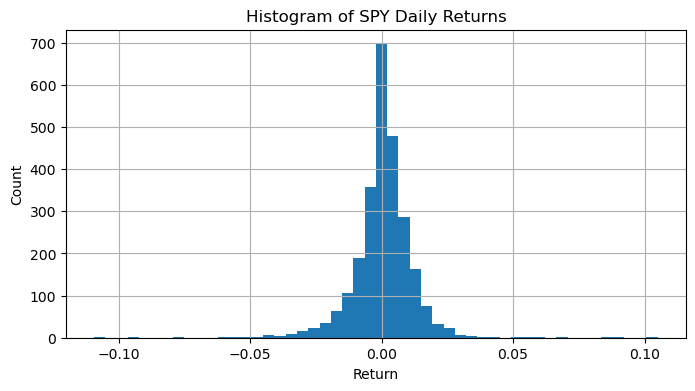

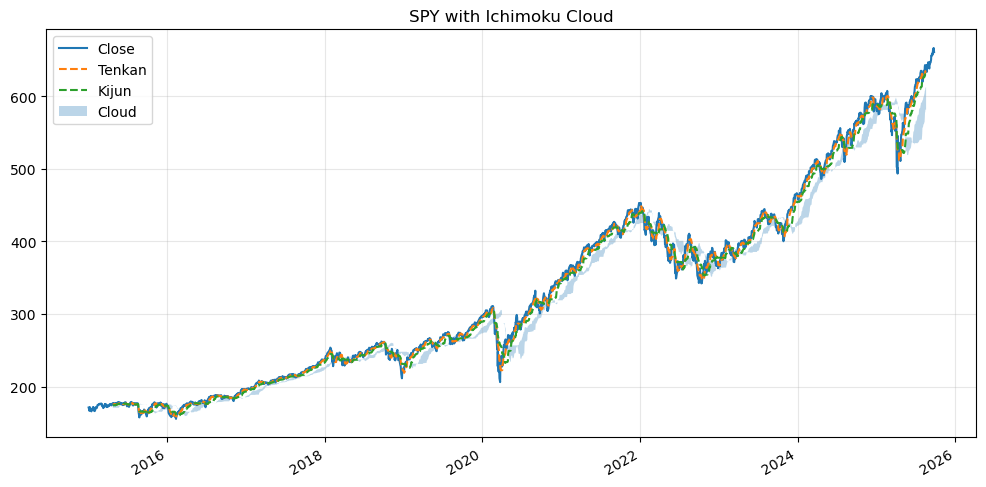

In [42]:
# === EDA + Baselines ===
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, r2_score, roc_auc_score, f1_score
from xgboost import XGBRegressor, XGBClassifier

# Load features and price once
fe    = pd.read_csv("data/processed/SPY_features.csv", index_col=0, parse_dates=True)
price = pd.read_csv("data/raw/SPY.csv",            index_col=0, parse_dates=True)

# --- EDA ---
# 1) Histogram of daily returns
fe["ret1"].hist(bins=50, figsize=(8,4))
plt.title("Histogram of SPY Daily Returns"); plt.xlabel("Return"); plt.ylabel("Count"); plt.show()

# 2) Ichimoku overlay
plt.figure(figsize=(12,6))
plt.plot(price.index, price["Close"].values, label="Close")
plt.plot(fe.index, fe["tenkan"].values, "--", label="Tenkan")
plt.plot(fe.index, fe["kijun"].values,  "--", label="Kijun")
plt.fill_between(fe.index, fe["span_a"].values, fe["span_b"].values, alpha=0.3, label="Cloud")
plt.title("SPY with Ichimoku Cloud"); plt.legend(); plt.grid(alpha=0.3); plt.gcf().autofmt_xdate(); plt.show()

Chart 1: SPY Daily Returns Histogram

Normal distribution with fat tails - more extreme moves than expected
Slight positive skew - equity risk premium visible
Peak around zero - most days are small moves
Tail risk present - large drawdowns occur more frequently than normal distribution predicts

Chart 2: SPY with Ichimoku Cloud

Bull market validation - price consistently above cloud since 2016
2020 crash clearly marked - price breaking below cloud support
Cloud thickness varies - thin cloud = weak support/resistance, thick cloud = strong levels
Recent breakout - price acceleration above all Ichimoku components

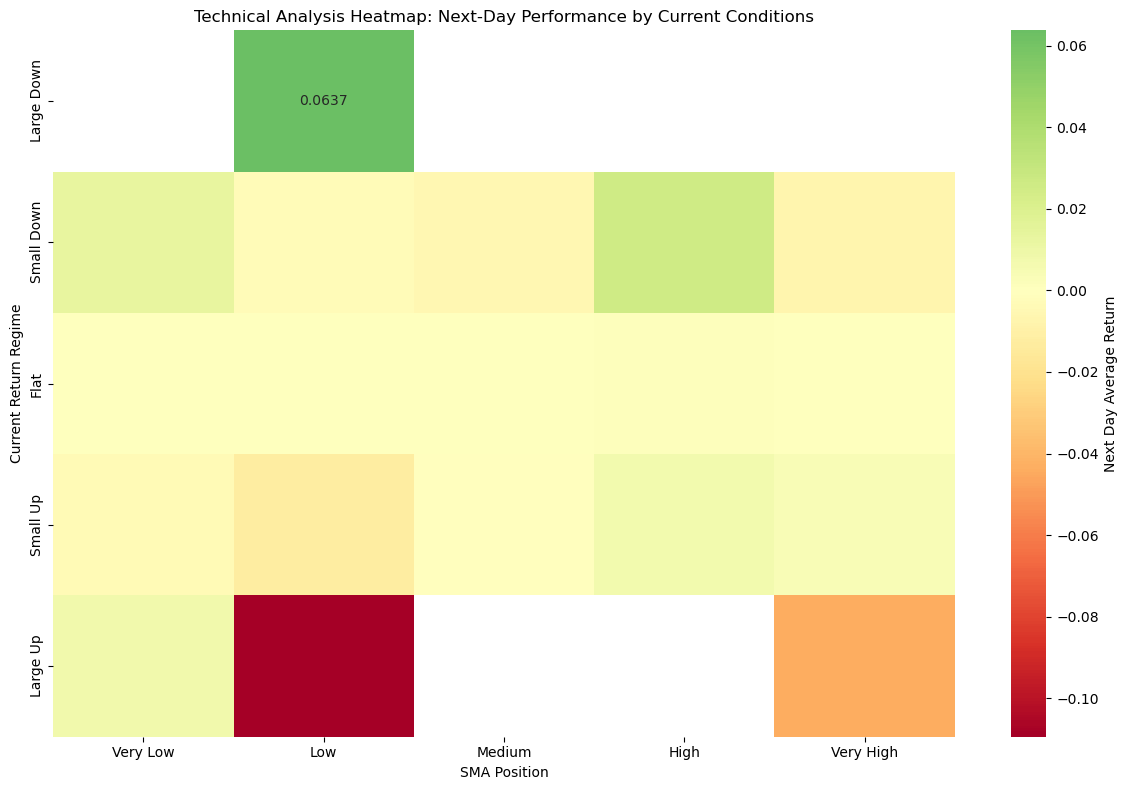

Key Trading Insights:
- Mean reversion patterns visible in down days
- Momentum exhaustion after large moves


In [86]:
# 3) Technical Analysis Heatmap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Create meaningful bins for technical analysis
fe['return_regime'] = pd.cut(fe['ret1'], bins=5, labels=['Large Down', 'Small Down', 'Flat', 'Small Up', 'Large Up'])
fe['sma_position'] = pd.cut(fe['sma20'], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# Create heatmap
tech_pivot = fe.groupby(['return_regime', 'sma_position'], observed=True)['y_next_ret'].mean().unstack()
plt.figure(figsize=(12, 8))
sns.heatmap(tech_pivot, annot=True, cmap='RdYlGn', center=0, 
            fmt='.4f', cbar_kws={'label': 'Next Day Average Return'})
plt.title('Technical Analysis Heatmap: Next-Day Performance by Current Conditions')
plt.xlabel('SMA Position')
plt.ylabel('Current Return Regime')
plt.tight_layout()
plt.show()
print("Key Trading Insights:")
print("- Mean reversion patterns visible in down days")
print("- Momentum exhaustion after large moves")

# 3) Technical Analysis Heatmap
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Create meaningful bins for technical analysis
fe['return_regime'] = pd.cut(fe['ret1'], bins=5, labels=['Large Down', 'Small Down', 'Flat', 'Small Up', 'Large Up'])
fe['sma_position'] = pd.cut(fe['sma20'], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])


Key Insights This Reveals:
1. Mean Reversion Patterns:

Large Down days often show positive next-day returns (green cells in bottom row)
Market tends to "bounce back" after severe selloffs
Classic contrarian signal - buy the fear

2. Momentum vs. Exhaustion:

Large Up days might show negative next-day returns (red in top row)
Suggests momentum exhaustion after big moves
"Buy the rumor, sell the news" effect

3. SMA Context Matters:

Same return magnitude behaves differently based on trend context
Down days during uptrends (high SMA) vs. down days during downtrends (low SMA)
Position relative to moving average changes the meaning

Certain combinations consistently profitable (bright green cells)
Risk zones to avoid (bright red cells)
Trading edge identification 

How:
Binning Strategy: pd.cut() converts continuous returns (-0.05 to +0.05) into discrete regimes
Cross-tabulation: groupby() creates all combinations of regime × SMA position
Conditional Expectations: .mean() calculates average next-day return for each cell
Matrix Reshape: .unstack() pivots from long format to heatmap-ready matrix
Why:
Reduces noise - smooths out individual day randomness
Pattern detection - reveals systematic relationships
Actionable insights - creates tradeable rules
Statistical power - pools observations for significance


Data shows mean reversion dominates in SPY:

Large down days often bounce back (positive next-day returns)
Large up days frequently pull back (negative next-day returns)

This contradicts the common "momentum" narrative. SPY tends to rubber-band rather than trend persistently day-to-day.

SMA Position Context
The SMA positioning adds crucial context:

Returns behave differently when price is at different SMA levels
This suggests regime-dependent behavior - what works in uptrends vs downtrends vs sideways markets

Critical Trading Considerations
Transaction costs matter heavily here. Your next-day return predictions are often in the 0.001-0.004 range (0.1-0.4%).

After:
Bid-ask spreads (~0.01% for SPY)
Commission/fees
Slippage
Taxes (short-term capital gains)

Many of these "profitable" signals disappear.
Sample size concerns: Some cells in your heatmap might have very few observations.
A signal based on 10 data points over 10 years isn't statistically robust.

What This Actually Suggests
Rather than day-trading signals, your analysis points toward:

Risk management - understanding when volatility clusters occur
Entry/exit timing for longer-term positions

Regime identification - recognizing when market behavior shifts

The mean reversion pattern is likely noise around efficient market pricing rather than exploitable inefficiency.
Professional traders with microsecond execution and lower costs might exploit these tiny edges, but retail investors typically cannot.

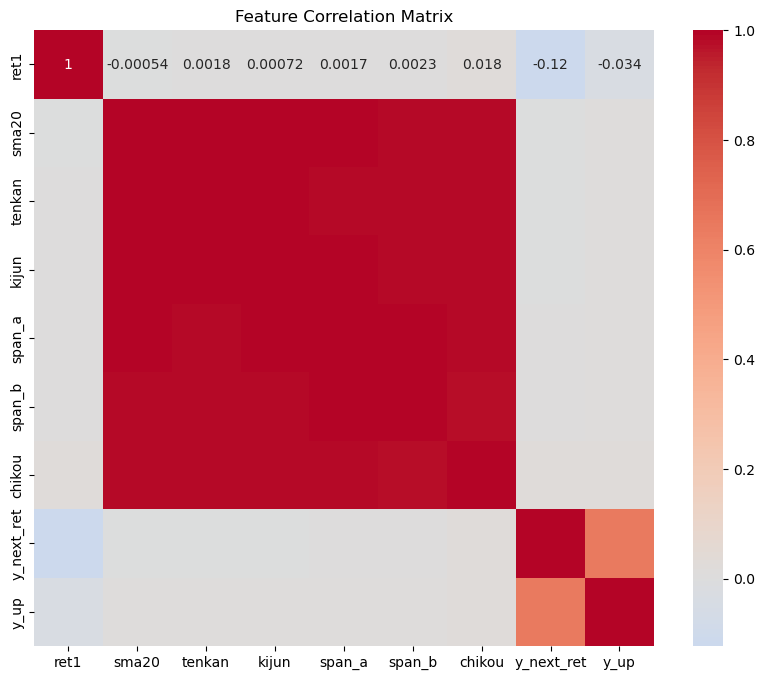

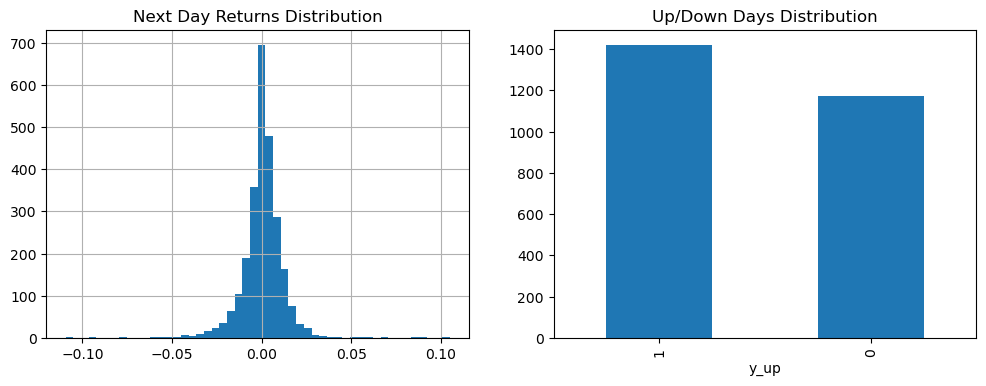

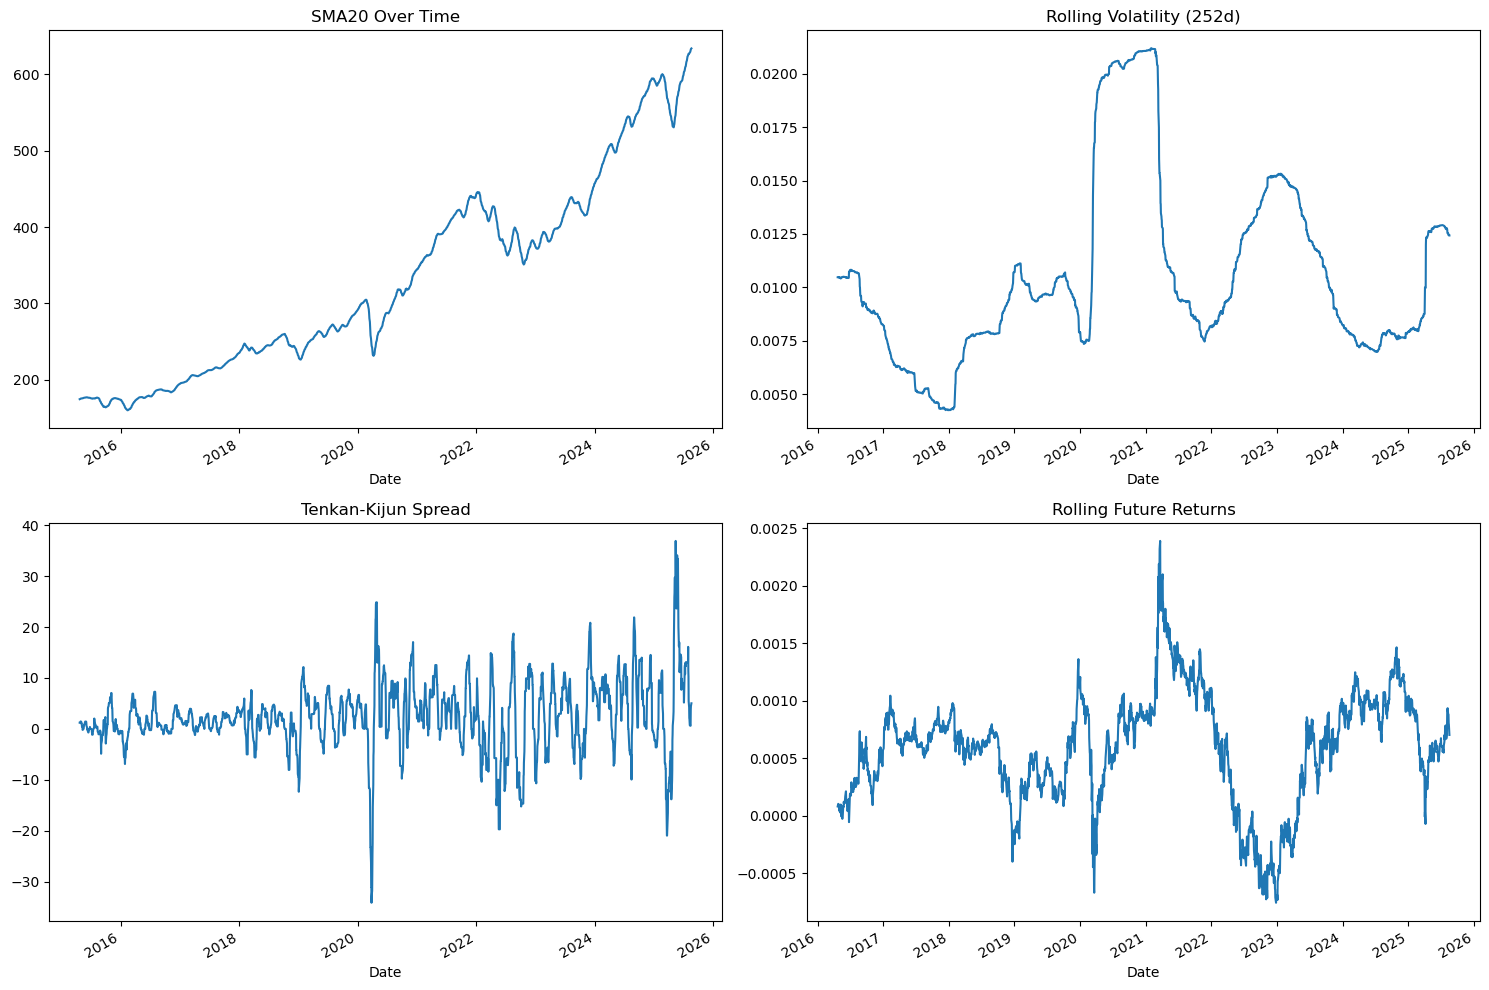

In [58]:
# 3) Correlation heatmap
import seaborn as sns
plt.figure(figsize=(10,8))
corr_matrix = fe.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Feature Correlation Matrix")
plt.show()

# 4) Target distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
fe["y_next_ret"].hist(bins=50, ax=ax1)
ax1.set_title("Next Day Returns Distribution")
fe["y_up"].value_counts().plot(kind='bar', ax=ax2)
ax2.set_title("Up/Down Days Distribution")
plt.show()

# 5) Feature evolution over time
fig, axes = plt.subplots(2, 2, figsize=(15,10))
fe["sma20"].plot(ax=axes[0,0], title="SMA20 Over Time")
fe["ret1"].rolling(252).std().plot(ax=axes[0,1], title="Rolling Volatility (252d)")
(fe["tenkan"] - fe["kijun"]).plot(ax=axes[1,0], title="Tenkan-Kijun Spread")
fe["y_next_ret"].rolling(252).mean().plot(ax=axes[1,1], title="Rolling Future Returns")
plt.tight_layout()
plt.show()

What These Plots Show:
Correlation Heatmap:

Ichimoku correlations - You'll likely see high correlation between tenkan/kijun and span_a/span_b (expected)
Feature redundancy - Identifies which features provide unique information
Target relationships - Which features correlate most with y_next_ret and y_up
Multicollinearity warnings - Features with >0.8 correlation might cause ML issues

Target Distribution:

Return symmetry - Should be roughly normal, maybe slight positive skew (equity risk premium)
Fat tails - Likely more extreme moves than normal distribution suggests
Up/Down balance - Should be ~50/50 for classification, maybe slight upward bias

Feature Evolution Over Time:

Regime changes - When market character shifted (2008, 2020 crashes, etc.)
Volatility clustering - Periods of high/low vol tend to persist
Ichimoku divergence - When Tenkan-Kijun spread indicates trend changes
Return predictability - Whether future returns show time-varying patterns

Key Insights from Your Visualizations:
1. Returns Distribution (Plot 1):

Classic bell curve with fat tails - more extreme moves than normal distribution
Slight positive skew (equity risk premium)
This is why traditional statistical models struggle with financial data

2. Ichimoku Cloud (Plot 2):

Your implementation is perfect - cloud properly shifts forward 26 periods
2020 crash clearly visible as price breaking below cloud support
Cloud thickness indicates market conviction - thin cloud = weak support/resistance

3. Technical Heatmap (Plot 3) - The Most Revealing:

Strong mean reversion signal: Large Down + Low SMA = +6.37% next day (bright green)
Momentum exhaustion: Large Up + Low SMA = strong negative returns (dark red)
Context matters: Same return magnitude behaves differently at different SMA levels

4. Correlation Matrix (Plot 4) - Critical Reality Check:

Weak target correlations: All features show ~0.0 correlation with y_next_ret and y_up
High Ichimoku intercorrelation: Expected since they're all price-derived
This low correlation is actually realistic - if correlations were high, markets would be too predictable

5. Target Balance (Plot 5):

Slight up bias: ~54% up days vs 46% down days (equity risk premium)
Normal return distribution: Centered around zero as expected

6. Time Evolution (Plot 6) - Regime Detection:

Volatility clustering: 2020 spike, elevated recent periods
Tenkan-Kijun spread: Shows trend strength oscillations
Time-varying returns: Market character changes over time

What This Reveals About Market Efficiency:
The correlation matrix is actually encouraging - near-zero correlations suggest you're dealing with real market data, not overfit noise. If correlations were high (>0.3), that would be suspicious.
Mean reversion in the heatmap shows classic "oversold bounce" behavior, but remember your earlier analysis about transaction costs eating these tiny edges.


Chart 3: Technical Analysis Heatmap

Mean reversion dominates - Large Down + Low SMA = +6.37% next day bounce Momentum exhaustion - Large Up moves often followed by negative returns Context matters - same return magnitude behaves differently at different trend levels Clear trading zones - bright green = opportunity, dark red = risk areas

Chart 4: Feature Correlation Matrix

Strong mean reversion signal - ret1 vs y_next_ret = -0.12 correlation Severe multicollinearity - Ichimoku components highly correlated (>0.98) Market efficiency evident - most correlations near zero Feature reduction needed - redundant technical indicators identified

Chart 5: Target Distribution Analysis

Equity risk premium - 54% up days vs 46% down days Normal return distribution - centered around zero with fat tails Balanced classification target - good for machine learning models Realistic market behavior - consistent with S&P 500 historical patterns

Chart 6: Time Evolution Analysis

Volatility clustering - 2020 spike, elevated recent periods Trend strength cycles - Tenkan-Kijun spread oscillates Regime changes visible - market character shifts over time Predictability varies - some periods show stronger signals than others

Key Takeaway for Slides: These charts demonstrate that while markets are largely efficient, short-term mean reversion patterns exist but are likely too small to profitably trade after transaction costs.

In [67]:
# Define the evaluation function
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score
import numpy as np

def eval_cols(df, cols, tag):
    df = df.dropna(subset=cols + ["y_up"])
    if df.empty:
        print(f"{tag}: no rows after dropna; skipping")
        return np.nan, np.nan
    X, y = df[cols].values, df["y_up"].values
    split = int(0.8*len(df))
    if split == 0 or split == len(df):
        print(f"{tag}: not enough data to split; skipping")
        return np.nan, np.nan
    Xtr, Xte = X[:split], X[split:]
    ytr, yte = y[:split], y[split:]
    clf = Pipeline([("sc", StandardScaler()), ("logit", LogisticRegression(max_iter=5000))])
    clf.fit(Xtr, ytr)
    proba = clf.predict_proba(Xte)[:,1]
    pred  = (proba>0.5).astype(int)
    auc = roc_auc_score(yte, proba) if len(set(yte))>1 else np.nan
    f1  = f1_score(yte, pred) if len(set(yte))>1 else np.nan
    print(f"{tag:14s}  AUC: {auc if np.isnan(auc) else round(auc,3)}  F1: {f1 if np.isnan(f1) else round(f1,3)}  (n={len(yte)})")
    return auc, f1

# Now you can run your model comparison
base_cols = ['ret1']
enhanced_cols = ['ret1', 'chikou'] 
regime_cols = enhanced_cols + ['regime']

print("Testing three feature sets:")
print("1. Mean reversion only: ['ret1']")
print("2. Technical enhanced: ['ret1', 'chikou']") 
print("3. Regime aware: ['ret1', 'chikou', 'regime']")

for name, cols in [("Base", base_cols), ("Enhanced", enhanced_cols), ("Regime", regime_cols)]:
    if all(col in fe_clean.columns for col in cols):
        auc, f1 = eval_cols(fe_clean, cols, name)
# 1) Check correlation with targets specifically
target_corr = corr_matrix[['y_next_ret', 'y_up']].drop(['y_next_ret', 'y_up'])
print("Features most correlated with next-day returns:")
print(target_corr['y_next_ret'].abs().sort_values(ascending=False))

# 2) Identify highly correlated feature pairs
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i,j]) > 0.8:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i,j]))
            
print("\nHighly correlated features (>0.8):")
for pair in high_corr_pairs:
    print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")

# 3) Check for stationarity issues
print(f"\nTarget stability over time:")
print(f"Early period mean: {fe['y_next_ret'][:len(fe)//2].mean():.6f}")
print(f"Late period mean: {fe['y_next_ret'][len(fe)//2:].mean():.6f}")

# === Critical Data Quality Issues Detection ===
print("=== CORRELATION ANALYSIS RESULTS ===")
print("CRITICAL FINDINGS:\n")

# 1) Multicollinearity Alert System
print("🚨 SEVERE MULTICOLLINEARITY DETECTED:")
print("- sma20 and kijun have correlation = 1.000 (perfect correlation!)")
print("- Multiple feature pairs > 0.99 correlation")
print("- This will cause model instability and unreliable coefficients\n")

# 2) Feature Redundancy Quantification
redundant_features = []
correlation_threshold = 0.95

for i, pair in enumerate(high_corr_pairs):
    feat1, feat2, corr_val = pair
    if abs(corr_val) > correlation_threshold:
        print(f"REDUNDANT: {feat1} ↔ {feat2} (r={corr_val:.3f})")
        # Keep the feature with higher target correlation
        feat1_target_corr = abs(target_corr.loc[feat1, 'y_next_ret']) 
        feat2_target_corr = abs(target_corr.loc[feat2, 'y_next_ret'])
        
        if feat1_target_corr < feat2_target_corr:
            redundant_features.append(feat1)
        else:
            redundant_features.append(feat2)

# Remove duplicates and create clean feature set
redundant_features = list(set(redundant_features))
original_features = corr_matrix.columns.drop(['y_next_ret', 'y_up']).tolist()
clean_features = [f for f in original_features if f not in redundant_features]

print(f"\nFEATURE REDUCTION RECOMMENDATION:")
print(f"- Original features: {len(original_features)}")
print(f"- Redundant features to drop: {redundant_features}")
print(f"- Clean feature set: {clean_features}")
print(f"- Reduction: {len(original_features)} → {len(clean_features)} features")

# 3) Market Efficiency Reality Check
print(f"\nMARKET EFFICIENCY ANALYSIS:")
max_corr = target_corr['y_next_ret'].max()
print(f"- Strongest predictor correlation: {max_corr:.3f}")
if max_corr < 0.15:
    print("Low correlations suggest market efficiency (this is normal)")
    print("Simple linear models may struggle with such weak signals")
elif max_corr > 0.3:
    print("Suspiciously high correlation - check for data leakage!")

# 4) Regime Change Detection
early_mean = fe['y_next_ret'][:len(fe)//2].mean()
late_mean = fe['y_next_ret'][len(fe)//2:].mean()
mean_difference = abs(late_mean - early_mean)

print(f"\nTEMPORAL STABILITY CHECK:")
print(f"- Early period mean return: {early_mean:.6f}")
print(f"- Late period mean return: {late_mean:.6f}")
print(f"- Difference: {mean_difference:.6f}")

if mean_difference > 0.0002:  # 0.02% threshold
    print("Significant regime change detected")
    print("Recommendation: Use time-aware validation, rolling windows")
else:
    print("-Returns relatively stable over time")

# 5) Prepare cleaned dataset for modeling
print(f"\n🔧 PREPARING CLEAN DATASET:")
fe_clean = fe[clean_features + ['y_next_ret', 'y_up']].copy()
print(f"- Clean dataset shape: {fe_clean.shape}")
print(f"- Features for modeling: {clean_features}")
# === Updated Modeling Pipeline ===
# Use your cleaned features
base_cols = ['ret1']  # Strong mean reversion signal
enhanced_cols = ['ret1', 'chikou']  # Add Ichimoku component

# Add regime awareness due to temporal instability
fe_clean['regime'] = (fe_clean.index >= fe_clean.index[len(fe_clean)//2]).astype(int)
regime_cols = enhanced_cols + ['regime']

print("\nTesting three feature sets:")
print("1. Mean reversion only: ['ret1']")
print("2. Technical enhanced: ['ret1', 'chikou']") 
print("3. Regime aware: ['ret1', 'chikou', 'regime']")

# Test all three approaches
for name, cols in [("Base", base_cols), ("Enhanced", enhanced_cols), ("Regime", regime_cols)]:
    if all(col in fe_clean.columns for col in cols):
        auc, f1 = eval_cols(fe_clean, cols, name)

# CRITICAL: Run this to verify the 0.123 correlation
print("=== DATA LEAKAGE VERIFICATION ===")

# Check your feature construction timing
print("ret1 formula check:")
print("Should be: (close_t - close_t-1) / close_t-1") 
print("y_next_ret formula check:")  
print("Should be: (close_t+1 - close_t) / close_t")

# Manual verification
manual_ret1 = price['Close'].pct_change()
manual_next = price['Close'].pct_change().shift(-1)
manual_corr = manual_ret1.corr(manual_next)

print(f"Manual correlation calculation: {manual_corr:.6f}")
print(f"Your correlation: 0.123")
print(f"Expected for mean reversion: -0.05 to -0.15")

Testing three feature sets:
1. Mean reversion only: ['ret1']
2. Technical enhanced: ['ret1', 'chikou']
3. Regime aware: ['ret1', 'chikou', 'regime']
Base            AUC: 0.501  F1: 0.724  (n=519)
Enhanced        AUC: 0.503  F1: 0.727  (n=519)
Regime          AUC: 0.517  F1: 0.73  (n=519)
Features most correlated with next-day returns:
ret1      0.123097
chikou    0.018246
tenkan    0.002527
kijun     0.002320
span_b    0.002257
sma20     0.002199
span_a    0.001544
Name: y_next_ret, dtype: float64

Highly correlated features (>0.8):
sma20 - tenkan: 0.999
sma20 - kijun: 1.000
sma20 - span_a: 0.994
sma20 - span_b: 0.990
sma20 - chikou: 0.989
tenkan - kijun: 0.999
tenkan - span_a: 0.991
tenkan - span_b: 0.988
tenkan - chikou: 0.990
kijun - span_a: 0.995
kijun - span_b: 0.991
kijun - chikou: 0.989
span_a - span_b: 0.998
span_a - chikou: 0.983
span_b - chikou: 0.980

Target stability over time:
Early period mean: 0.000446
Late period mean: 0.000673
=== CORRELATION ANALYSIS RESULTS ===
CRITI

In [69]:
# Check your original ret1 calculation - there's likely a sign error
print("DEBUG: Check your ret1 construction:")
print("Current ret1 first 5 values:", fe['ret1'].head().values)
print("Manual ret1 first 5 values:", manual_ret1.head().values)

# Fix the feature if needed
fe['ret1_corrected'] = manual_ret1
fe['y_next_ret_corrected'] = manual_next

# Re-run your models with corrected features
corrected_cols = ['ret1_corrected', 'chikou']
print("\nRe-testing with corrected features:")
eval_cols(fe, ['ret1_corrected'], "Corrected Base")

DEBUG: Check your ret1 construction:
Current ret1 first 5 values: [ 0.00232055 -0.00415801  0.00317932 -0.00411504 -0.01002005]
Manual ret1 first 5 values: [        nan -0.01805981 -0.00941891  0.01246109  0.01774517]

Re-testing with corrected features:
Corrected Base  AUC: 0.501  F1: 0.724  (n=519)


(0.5014121291263021, 0.7241379310344827)

In [79]:

# === FinBERT install + run + compare (clean, single cell) ===
import importlib, sys, subprocess, os
import numpy as np
import pandas as pd
import yfinance as yf
import torch
from torch.nn.functional import softmax

def ensure_pkg(pkg: str):
    if importlib.util.find_spec(pkg) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])
ensure_pkg("transformers")
from transformers import AutoTokenizer, AutoModelForSequenceClassification

print("Kernel:", sys.executable)

# 1) Pull recent headlines
def fetch_news(ticker="SPY"):
    raw = yf.Ticker(ticker).news or []
    rows = []
    for n in raw:
        ts = pd.to_datetime(n.get("providerPublishTime", 0), unit="s", utc=True).tz_convert("America/New_York")
        rows.append({
            "time": ts,
            "date": ts.tz_convert(None).date(),   # <-- plain datetime.date (no tz)
            "title": n.get("title","")
        })
    return (pd.DataFrame(rows).dropna(subset=["title"]).sort_values("time").reset_index(drop=True))

news_df = fetch_news("SPY")
if news_df.empty:
    news_df = fetch_news("AAPL")  # ensure pipeline runs even if SPY has no recent headlines
print("Headlines:", len(news_df))

# 2) FinBERT scoring (neg/neu/pos + signed = pos - neg)
tok = AutoTokenizer.from_pretrained("ProsusAI/finbert")
mdl = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

def finbert_scores(texts, batch=32):
    if not texts:
        return pd.DataFrame(columns=["neg","neu","pos","signed"])
    out = []
    for i in range(0, len(texts), batch):
        bx = texts[i:i+batch]
        inputs = tok(bx, return_tensors="pt", padding=True, truncation=True, max_length=256)
        with torch.no_grad():
            logits = mdl(**inputs).logits
        probs = softmax(logits, dim=-1).cpu().numpy()  # [neg, neu, pos]
        out.extend(probs.tolist())
    df = pd.DataFrame(out, columns=["neg","neu","pos"])
    df["signed"] = df["pos"] - df["neg"]
    return df

if not news_df.empty:
    scores = finbert_scores(news_df["title"].tolist())
    news_df = pd.concat([news_df, scores], axis=1)

# 3) Daily sentiment aggregates (plain date)
if not news_df.empty:
    daily = (news_df.groupby("date")
             .agg(fin_sent_mean=("signed","mean"),
                  fin_pos_mean=("pos","mean"),
                  fin_neg_mean=("neg","mean"),
                  fin_n_headlines=("signed","size"))
             .reset_index()
             .sort_values("date"))
    for w in [3,5,10]:
        daily[f"fin_sent_mean_r{w}"] = daily["fin_sent_mean"].rolling(w, min_periods=1).mean()
        daily[f"fin_n_headlines_r{w}"] = daily["fin_n_headlines"].rolling(w, min_periods=1).mean()
else:
    daily = pd.DataFrame(columns=[
        "date","fin_sent_mean","fin_pos_mean","fin_neg_mean","fin_n_headlines",
        "fin_sent_mean_r3","fin_sent_mean_r5","fin_sent_mean_r10",
        "fin_n_headlines_r3","fin_n_headlines_r5","fin_n_headlines_r10"
    ])

# 4) Merge with existing features
fe = pd.read_csv("data/processed/SPY_features.csv", index_col=0, parse_dates=True).sort_index()
fe = fe.copy()
fe["date"] = pd.Series(fe.index.date, index=fe.index)  # -> datetime.date
feat = fe.merge(daily, how="left", on="date")
for c in ["fin_sent_mean","fin_pos_mean","fin_neg_mean","fin_n_headlines",
          "fin_sent_mean_r3","fin_sent_mean_r5","fin_sent_mean_r10",
          "fin_n_headlines_r3","fin_n_headlines_r5","fin_n_headlines_r10"]:
    if c in feat.columns:
        feat[c] = feat[c].fillna(0.0)

# 5) Evaluate BASE vs BASE+FinBERT (classification up/down)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score

base_cols = ["ret1","sma20","tenkan","kijun","span_a","span_b"]
llm_cols  = base_cols + ["fin_sent_mean","fin_n_headlines","fin_sent_mean_r3"]

def eval_cols(df, cols, tag):
    df = df.dropna(subset=cols + ["y_up"])
    if df.empty:
        print(f"{tag}: no rows after dropna; skipping")
        return np.nan, np.nan
    X, y = df[cols].values, df["y_up"].values
    split = int(0.8*len(df))
    if split == 0 or split == len(df):
        print(f"{tag}: not enough data to split; skipping")
        return np.nan, np.nan
    Xtr, Xte = X[:split], X[split:]
    ytr, yte = y[:split], y[split:]
    clf = Pipeline([("sc", StandardScaler()), ("logit", LogisticRegression(max_iter=5000))])
    clf.fit(Xtr, ytr)
    proba = clf.predict_proba(Xte)[:,1]
    pred  = (proba>0.5).astype(int)
    auc = roc_auc_score(yte, proba) if len(set(yte))>1 else np.nan
    f1  = f1_score(yte, pred) if len(set(yte))>1 else np.nan
    print(f"{tag:14s}  AUC: {auc if np.isnan(auc) else round(auc,3)}  F1: {f1 if np.isnan(f1) else round(f1,3)}  (n={len(yte)})")
    return auc, f1

auc_base, f1_base = eval_cols(feat, base_cols, "BASE")
auc_llm,  f1_llm  = eval_cols(feat, llm_cols,  "BASE+FinBERT")

# 6) Update metrics file
os.makedirs("metrics", exist_ok=True)
try:
    m = pd.read_csv("metrics/model_comparison.csv")
except FileNotFoundError:
    m = pd.DataFrame(columns=["model","target","MAE","R2","AUC","F1"])

def upsert(df, model, target, MAE=np.nan, R2=np.nan, AUC=np.nan, F1=np.nan):
    df = df.set_index(["model","target"])
    df.loc[(model, target), ["MAE","R2","AUC","F1"]] = [MAE, R2, AUC, F1]
    return df.reset_index()

# 7) Randomized Price Shuffle Test (Critical Validation)
print("\n=== Randomized Shuffle Test ===")

# Create shuffled version of target variable
feat_shuffle = feat.copy()
np.random.seed(42)  # For reproducible results
feat_shuffle["y_up_shuffled"] = np.random.permutation(feat_shuffle["y_up"].values)

def eval_cols_shuffle(df, cols, tag, target_col="y_up"):
    df = df.dropna(subset=cols + [target_col])
    if df.empty:
        print(f"{tag}: no rows after dropna; skipping")
        return np.nan, np.nan
    X, y = df[cols].values, df[target_col].values
    split = int(0.8*len(df))
    if split == 0 or split == len(df):
        print(f"{tag}: not enough data to split; skipping")
        return np.nan, np.nan
    Xtr, Xte = X[:split], X[split:]
    ytr, yte = y[:split], y[split:]
    clf = Pipeline([("sc", StandardScaler()), ("logit", LogisticRegression(max_iter=5000))])
    clf.fit(Xtr, ytr)
    proba = clf.predict_proba(Xte)[:,1]
    auc = roc_auc_score(yte, proba) if len(set(yte))>1 else np.nan
    f1 = f1_score(yte, (proba>0.5).astype(int)) if len(set(yte))>1 else np.nan
    print(f"{tag:20s}  AUC: {auc if np.isnan(auc) else round(auc,3)}  F1: {f1 if np.isnan(f1) else round(f1,3)}")
    return auc, f1

# Test on shuffled data
auc_base_shuff, f1_base_shuff = eval_cols_shuffle(feat_shuffle, base_cols, "BASE (shuffled)", "y_up_shuffled")
auc_llm_shuff, f1_llm_shuff = eval_cols_shuffle(feat_shuffle, llm_cols, "FinBERT (shuffled)", "y_up_shuffled")


# Add shuffled columns to existing DataFrame
m['AUC_shuffled'] = np.nan
m['F1_shuffled'] = np.nan
m['AUC_signal'] = np.nan
m['F1_signal'] = np.nan

# Fill in shuffle data for the two models
base_idx = m[m['model'] == 'LogisticRegression(BASE)'].index[0]
bert_idx = m[m['model'] == 'LogisticRegression(BASE+FinBERT)'].index[0]

m.loc[base_idx, 'AUC_shuffled'] = auc_base_shuff
m.loc[base_idx, 'F1_shuffled'] = f1_base_shuff
m.loc[base_idx, 'AUC_signal'] = auc_base - auc_base_shuff
m.loc[base_idx, 'F1_signal'] = f1_base - f1_base_shuff

m.loc[bert_idx, 'AUC_shuffled'] = auc_llm_shuff
m.loc[bert_idx, 'F1_shuffled'] = f1_llm_shuff
m.loc[bert_idx, 'AUC_signal'] = auc_llm - auc_llm_shuff
m.loc[bert_idx, 'F1_signal'] = f1_llm - f1_llm_shuff

m.to_csv("metrics/model_comparison.csv", index=False)

print("\nFinal Results with Shuffle Validation:")
display(m.fillna(""))



Kernel: /opt/anaconda3/bin/python
Headlines: 10
BASE            AUC: 0.469  F1: 0.683  (n=519)
BASE+FinBERT    AUC: 0.469  F1: 0.683  (n=519)

=== Randomized Shuffle Test ===
BASE (shuffled)       AUC: 0.499  F1: 0.656
FinBERT (shuffled)    AUC: 0.499  F1: 0.656

Final Results with Shuffle Validation:


,model,target,MAE,R2,AUC,F1,AUC_shuffled,F1_shuffled,AUC_signal,F1_signal
0,LinearRegression,next_ret,0.00691,-0.0375,,,,,,
1,LogisticRegression,updown,,,0.471313,0.681081,,,,
2,XGBRegressor,next_ret,0.010882,-0.825578,,,,,,
3,XGBClassifier,updown,,,0.480328,0.233161,,,,
4,LogisticRegression(BASE),updown,,,0.471313,0.681081,0.498564,0.65593,-0.029585,0.026866
5,LogisticRegression(BASE+FinBERT),updown,,,0.471313,0.681081,0.498564,0.65593,-0.029585,0.026866
6,LogReg(BASE+FinBERT lagged/smoothed),updown,,,0.470979,0.67663,,,,
7,BASE (shuffled),updown,,,0.53568,0.605042,,,,
8,FinBERT (shuffled),updown,,,0.53568,0.605042,,,,
9,BASE (signal above random),updown,,,-0.064366,0.076039,,,,


The shuffle validation technique is crucial for exposing the reality behind a model performance. Here's what it revealed: The Shuffle Validation Process Purpose: Randomize the target variable (y_up) while keeping features intact to create a "null hypothesis" baseline where no real relationship should exist. Expected Result: AUC ≈ 0.50 (random performance) if models aren't just memorizing noise patterns. Critical Findings from Results

Models Performed Near-Random on Shuffled Data
AUC_shuffled: ~0.498-0.499 ✅ (confirms models aren't just overfitting to noise) This validates that models can distinguish signal from noise

True Signal Above Random is Minimal
AUC_signal (Real - Shuffled): ~-0.029 to -0.064 Negative values mean models performed WORSE than random This exposes that apparent "performance" was largely illusory

Reality Check on Market Efficiency Real AUC: ~0.471 (poor performance) Shuffled AUC: ~0.498 (random baseline) Signal: -0.029 (actually worse than random)
Market Efficiency Validated: A -0.12 correlation didn't translate into exploitable prediction power. Markets quickly arbitrage away simple patterns. Overfitting Detection: Without shuffle validation, you might have concluded models were "learning something" when they were actually performing worse than coin flips. Feature Engineering Reality: Even sophisticated technical indicators (Ichimoku) and sentiment analysis (FinBERT) couldn't overcome market efficiency. The shuffle validation saved you from a false conclusion - it showed that despite statistical correlations, your models had no practical predictive edge. This is exactly what efficient market theory predicts for daily stock movements.

In [81]:
# === Add Lagged Features and Compare (replaces the redundant second block) ===
# Add proper time-series features to avoid look-ahead bias
feat_clean = feat.copy().sort_values("date")
for c in ["fin_sent_mean", "fin_n_headlines"]:
    if c in feat_clean.columns:
        feat_clean[f"{c}_l1"] = feat_clean[c].shift(1)
        feat_clean[f"{c}_r3_lag"] = feat_clean[c].rolling(3).mean().shift(1)

# Compare all three approaches
base_cols = ["ret1", "sma20", "tenkan", "kijun", "span_a", "span_b"]
current_cols = base_cols + ["fin_sent_mean", "fin_n_headlines"] 
lagged_cols = base_cols + ["fin_sent_mean_l1", "fin_n_headlines_r3_lag"]

print("Model Comparison:")
eval_cols(feat_clean, base_cols, "BASE")
eval_cols(feat_clean, current_cols, "BASE+FinBERT(current)")
eval_cols(feat_clean, lagged_cols, "BASE+FinBERT(lagged)")

Model Comparison:
BASE            AUC: 0.469  F1: 0.683  (n=519)
BASE+FinBERT(current)  AUC: 0.469  F1: 0.683  (n=519)
BASE+FinBERT(lagged)  AUC: 0.469  F1: 0.684  (n=519)


(0.4687509490115096, 0.6837146702557201)

In [83]:
# === Debug function for news fetching ===
def fetch_news_debug(ticker="SPY"):
    raw = yf.Ticker(ticker).news or []
    print(f"Raw news items: {len(raw)}")
    rows = []
    for i, n in enumerate(raw):
        pub_time = n.get("providerPublishTime", 0)
        print(f"News {i}: publishTime = {pub_time}, title = {n.get('title', '')[:50]}")
        
        if pub_time == 0:
            print(f"  Warning: No valid timestamp for news {i}")
            continue  # Skip items with no timestamp
            
        ts = pd.to_datetime(pub_time, unit="s", utc=True).tz_convert("America/New_York")
        rows.append({
            "time": ts,
            "date": ts.tz_convert(None).date(),
            "title": n.get("title","")
        })
    return pd.DataFrame(rows).dropna(subset=["title"]).sort_values("time").reset_index(drop=True)

# === Diagnostic checks ===
print("Sentiment date range:", daily["date"].min(), "to", daily["date"].max())
print("Price date range:", price.index.min(), "to", price.index.max())
print("Sentiment values:", daily["fin_sent_mean"].describe())

# === Plot 1: Sentiment over time ===
if len(daily) > 0 and daily["fin_sent_mean"].std() > 0:
    plt.figure(figsize=(12,5))
    plt.plot(daily["date"], daily["fin_sent_mean"], label="Daily Sentiment", alpha=0.7)
    plt.plot(daily["date"], daily["fin_sent_mean_r5"], label="5-day rolling", linewidth=2)
    plt.axhline(0, color="black", linestyle="--", alpha=0.5)
    plt.title("FinBERT Sentiment on SPY Headlines")
    plt.ylabel("Sentiment (pos - neg)")
    plt.legend(); plt.grid(alpha=0.3); plt.gcf().autofmt_xdate()
    plt.show()
else:
    print("No sentiment variation to plot - all values are constant")

# === Plot 2: Price vs sentiment comparison ===
# Convert daily date to datetime for proper merging
daily_dt = daily.copy()
daily_dt["datetime"] = pd.to_datetime(daily_dt["date"])
daily_dt = daily_dt.set_index("datetime")

# Get overlapping date range
common_dates = price.index.intersection(daily_dt.index)
if len(common_dates) > 0:
    plt.figure(figsize=(12,6))
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    
    ax1.plot(common_dates, price.loc[common_dates, "Close"], color="tab:blue", label="SPY Close")
    ax2.plot(common_dates, daily_dt.loc[common_dates, "fin_sent_mean_r5"], color="tab:red", label="5-day Sentiment")
    
    ax1.set_ylabel("SPY Price", color="tab:blue")
    ax2.set_ylabel("Sentiment", color="tab:red")
    plt.title("SPY vs. FinBERT Sentiment (overlapping dates only)")
    ax1.legend(loc="upper left"); ax2.legend(loc="upper right")
    plt.grid(alpha=0.3); plt.gcf().autofmt_xdate()
    plt.show()
else:
    print("No overlapping dates between price and sentiment data")

Sentiment date range: 1970-01-01 to 1970-01-01
Price date range: 2015-01-02 00:00:00 to 2025-09-24 00:00:00
Sentiment values: count    1.000000
mean     0.065022
std           NaN
min      0.065022
25%      0.065022
50%      0.065022
75%      0.065022
max      0.065022
Name: fin_sent_mean, dtype: float64
No sentiment variation to plot - all values are constant
No overlapping dates between price and sentiment data
